# Tutorial 7 - Intermolecular interactions

Welcome to the Intermolecular interactions tutorial !
In this notebook, we'll infer the diffusion interaction parameter of protein solution from the structure function obtained with DDM.


This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the basic tutorial 1 to 6.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `APPLICATION_DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686).

Your main directory tree should resemble the following:
```
.
├── APPLICATION_DATASET
│   └── ...
├── Tutorial_7-Intermolecular_interactions
│   └── Tutorial7.ipynb
│   └── ...
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of aqueous Bovine Serum Albumin (BSA, Sigma Aldrich #A7638) solutions at concentrations c ranging from $1.17$ to $34$ mg/mL, prepared by serial dilution in phosphate-buffered saline (PBS, ROTH #1058.1). The protein concentration in each sample was independently verified using a commercial UV spectrophotometer (ThermoFisher). The solutions were loaded into glass capillaries with a $3 \times 0.3$ mm rectangular cross-section (Vitrocom Inc.), which were sealed at both ends with epoxy glue to prevent evaporation.

The videos were acquired at 500 fps, using a Nikon Eclipse Ti-U inverted microscope equipped with a Orca
Flash 4.0 v2 (Hamamatsu) digital CMOS camera using a $20 ~ \times$, NA 0.5 microscope objective, yielding an efective pixel size $\delta _\mathrm{px} = 0.65 ~\mathrm{\mu m}$. For each sample, four videos were recorded at two locations in the mid-plane of the capillary. The exposure time (1.99 ms) and lamp intensity were held fixed for all acquisitions to ensure comparable noise levels.


### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
from ipywidgets import *

import os
import lmfit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText



def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0, 
    vmax: float = 0.9,
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

import fastddm as fddm
from fastddm.fit import fit

## Compute the image structure function and the azimuthal averages

In [2]:
main_dir = '../APPLICATION_DATASET/PROTEINS/'

# list of file names
file_names = [
    '20220907_BSA_A1/Data00001.tif',
    '20220907_BSA_A1/Data00003.tif',
    '20220907_BSA_A1/Data00005.tif',
    '20220907_BSA_A1/Data00007.tif',
    '20220907_BSA_A2/Data00001.tif',
    '20220907_BSA_A2/Data00003.tif',
    '20220907_BSA_A2/Data00005.tif',
    '20220907_BSA_A2/Data00007.tif',
    '20220907_BSA_A3/Data00001.tif',
    '20220907_BSA_A3/Data00003.tif',
    '20220907_BSA_A3/Data00005.tif',
    '20220907_BSA_A3/Data00007.tif',
    '20230330_BSA_A2diluted10x/Data_00001.tif',
    '20230330_BSA_A2diluted10x/Data_00003.tif',
    '20230330_BSA_A2diluted10x/Data_00005.tif',
    '20230330_BSA_A2diluted10x/Data_00007.tif',
]

# pixel size
pixel_size = [0.65] * len(file_names)    # micrometer/pixel

# frame rate
frame_rate = [500.0] * len(file_names)   # frames/s

# list of labels (we average the 2 runs at each position)
labels = [
    '34.0 mg/mL',
    '11.7 mg/mL',
    '5.8 mg/mL',
    '1.17 mg/mL',
]

conc = [34.0, 11.7, 5.8, 1.17]

In [3]:
# compute image structure function and azimuthal average
dqt = []
aa = []

for n, f in enumerate(file_names):
    print(f"Analyzing movie #{n+1} of {len(file_names)}...")
    # read image sequence
    img_seq = fddm.read_images(os.path.join(main_dir, f))
    
    # compute image structure function
    dqt.append(fddm.ddm(img_seq, range(1,len(img_seq)), core='cuda'))
    # set pixel size and time delay
    dqt[n].pixel_size = pixel_size[n]
    dqt[n].set_frame_rate(frame_rate[n])
    
    # compute azimuthal average
    # we go to high q, it's easier to just create a list of bin edges using delta_q as the unit
    # bin_size = dqt[n].ky[dqt[n].shape[1]//2+1]
    # bins = int(np.sqrt(dqt[n].ky[-1]**2 + dqt[n].kx[-2]**2)/bin_size)
    # bin_edges = [bin_size for i in range(bins)]
    bins = int(len(dqt[n].ky) / 2)                     # number of bins
    bin_range = (0, dqt[n].ky[-1])                     # bin range
    ccm = fddm.mask.central_cross_mask(dqt[n].shape[1:]) # mask for central cross
    # mask out the central cross
    ccm = fddm.mask.central_cross_mask(dqt[n].shape[1:])
    # compute
    aa.append(fddm.azimuthal_average(dqt[n], bins=bins, range=bin_range, mask=ccm))

Analyzing movie #1 of 16...
Analyzing movie #2 of 16...
Analyzing movie #3 of 16...
Analyzing movie #4 of 16...
Analyzing movie #5 of 16...
Analyzing movie #6 of 16...
Analyzing movie #7 of 16...
Analyzing movie #8 of 16...
Analyzing movie #9 of 16...
Analyzing movie #10 of 16...
Analyzing movie #11 of 16...
Analyzing movie #12 of 16...
Analyzing movie #13 of 16...
Analyzing movie #14 of 16...
Analyzing movie #15 of 16...
Analyzing movie #16 of 16...


## Resample the azimuthal average and average the data at each position

In [4]:
aa_res = []

for n, a in enumerate(aa):
    new_tau = fddm.lags.logspace_int(len(a.tau) // 2, num=50) * a.tau[0]
    if n % 4 == 0:
        aa_res.append(a.resample(new_tau))
        aa_res[-1]._err **= 2
    else:
        tmp = a.resample(new_tau)
        # average data
        aa_res[-1]._data += tmp._data
        # average error
        aa_res[-1]._err += tmp._err**2

for a in aa_res:
    a._data /= 4
    a._err = np.sqrt(a._err / 4)

## Estimate the noise factor

We estimate the noise using different methods...

In [5]:
Bq = []
Aq = []
for a in aa_res:
    B, _ = fddm.noise_est.estimate_camera_noise(
        a,
        mode="polyfit",
        num_points=10,
    )
    Bq.append(B)
    Aq.append(2.0 * a.var- B)

## Fit with simple exponential model

In [6]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 10

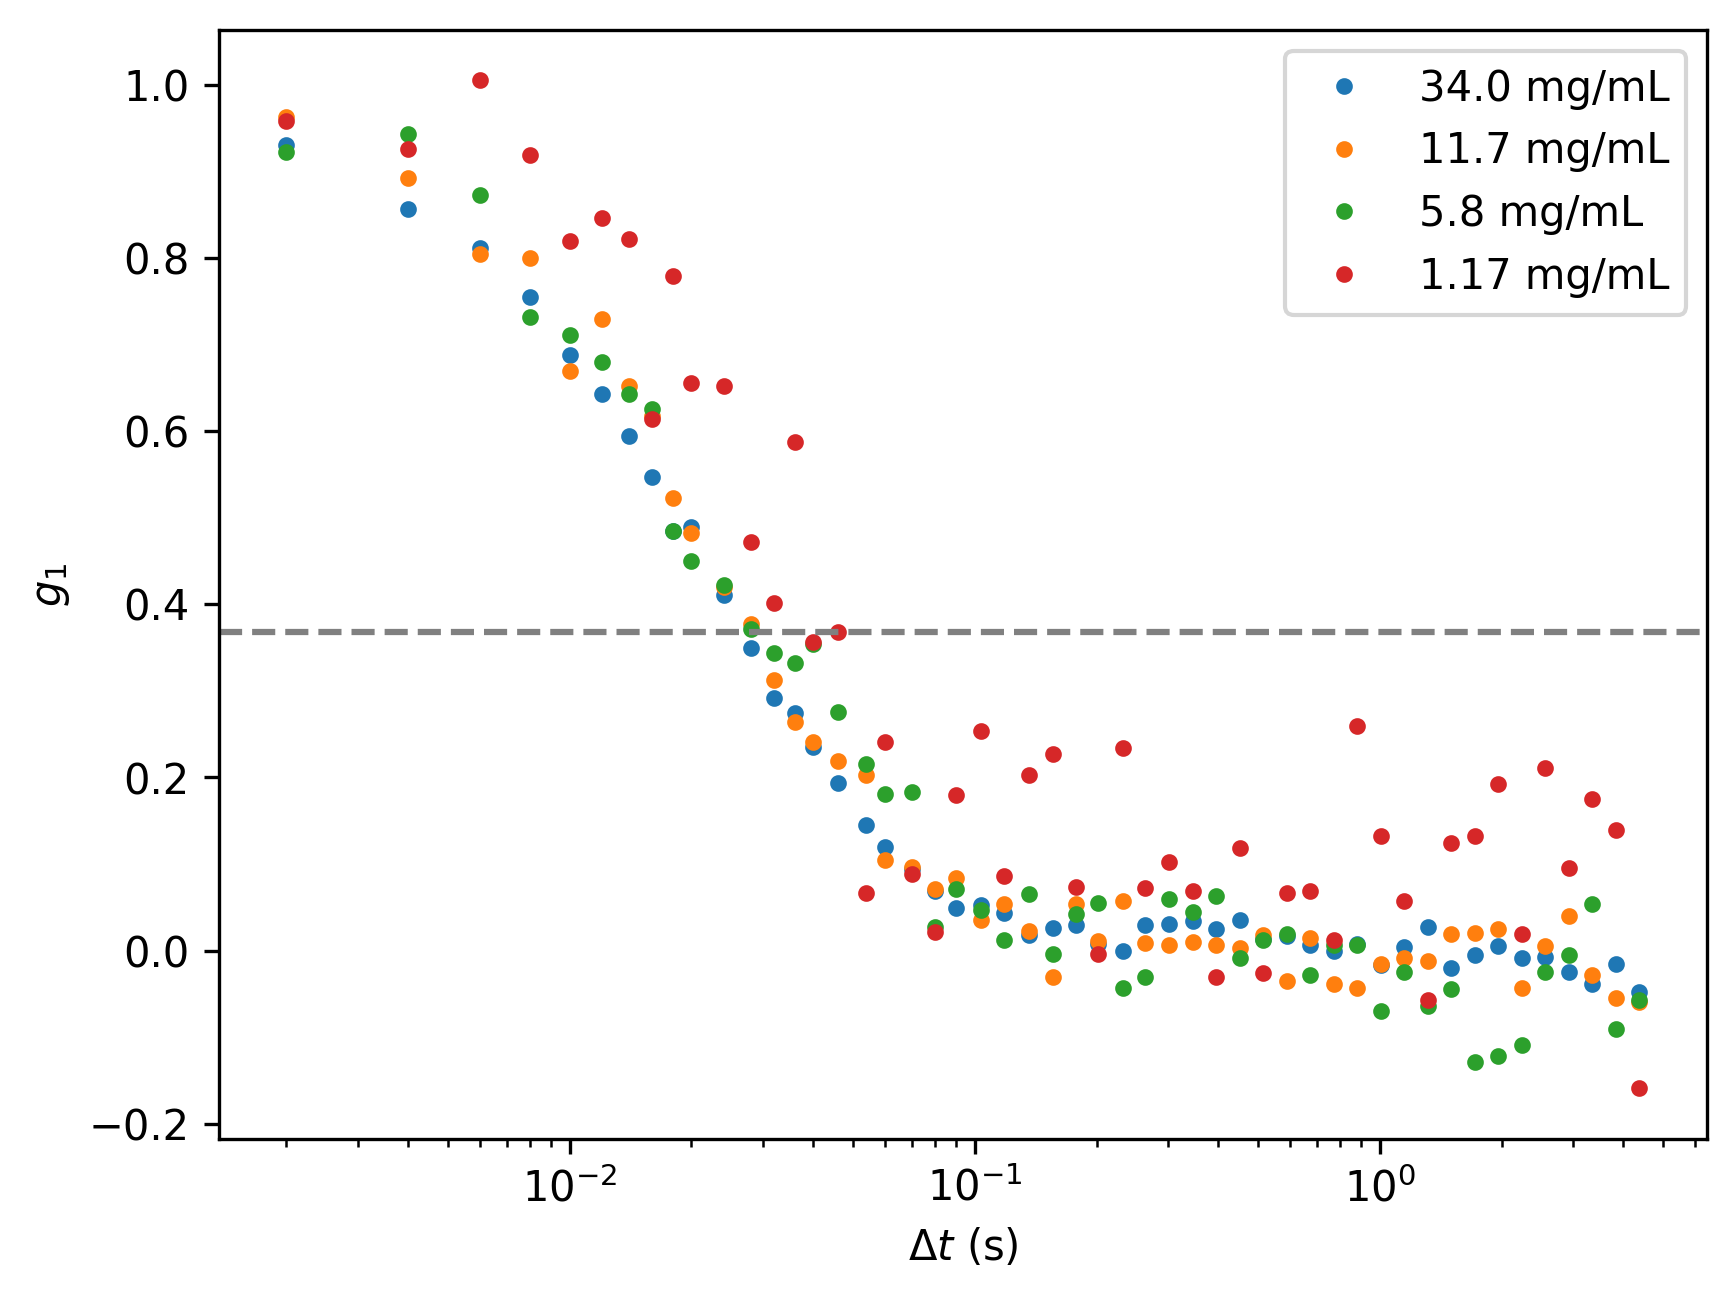

In [7]:
# show the curves at the reference k vector
fig1 = plt.figure(dpi = 300)
fig1.tight_layout()
ax1 = fig1.add_subplot(1, 1, 1)

for n, a in enumerate(aa_res):
    ax1.plot(a.tau, 1 - (a.data[k_ref] - Bq[n][k_ref])/Aq[n][k_ref], '.', label=labels[n])

ax1.axhline(y=np.exp(-1), color='gray', linestyle='--')
ax1.set_xscale('log')
ax1.set_xlabel(r'$\Delta t$ (s)')
ax1.set_ylabel(r'$g_1$')
ax1.legend();

In [8]:
fit_res = []
model_res = []

for n, a in enumerate(aa_res):
    # find reference tau
    y = 1 - (a.data[k_ref] - Bq[n][k_ref])/Aq[n][k_ref]
    tau = a.tau[np.argmin(np.abs(y-np.exp(-1)))]
    
    # set model parameters hints
    model.set_param_hint("B", value=Bq[n][k_ref])
    model.set_param_hint("A", value=Aq[n][k_ref])
    model.set_param_hint("Gamma", value=1/tau)
    
    # fix noise
    #fixed_params = {'A': 2.0 * a.var - B_est["polyfit"][n], 'B': B_est["polyfit"][n]}
    
    # weight data points with 1/sqrt(t)
    weights = 1 / np.sqrt(a.tau)
    
    # fit
    res, mres = fit_multik(a, model, k_ref, use_err=False, return_model_results=True, weights=weights)
    fit_res.append(res)
    model_res.append(mres)

## Relaxation rate fit results

[('34.0 mg/mL', 76.26058818525746, 0.816264348316711), ('11.7 mg/mL', 71.44945598094905, 2.2683058617093304), ('5.8 mg/mL', 69.24739412313933, 2.6859349105447543), ('1.17 mg/mL', 62.959879010332024, 9.032601000557644)]
D0: 67.96964587825208 +- 1.0598332200499407 mum2/s
kD: 0.0035979734565159127 +- 0.0005575604605873041 1/(mg/ml)
k: 194.20368583304204 +- 37.722907498610105 -
B2: 0.0002190139198887664 +- 0.00014237397136386505 mol mL/g2


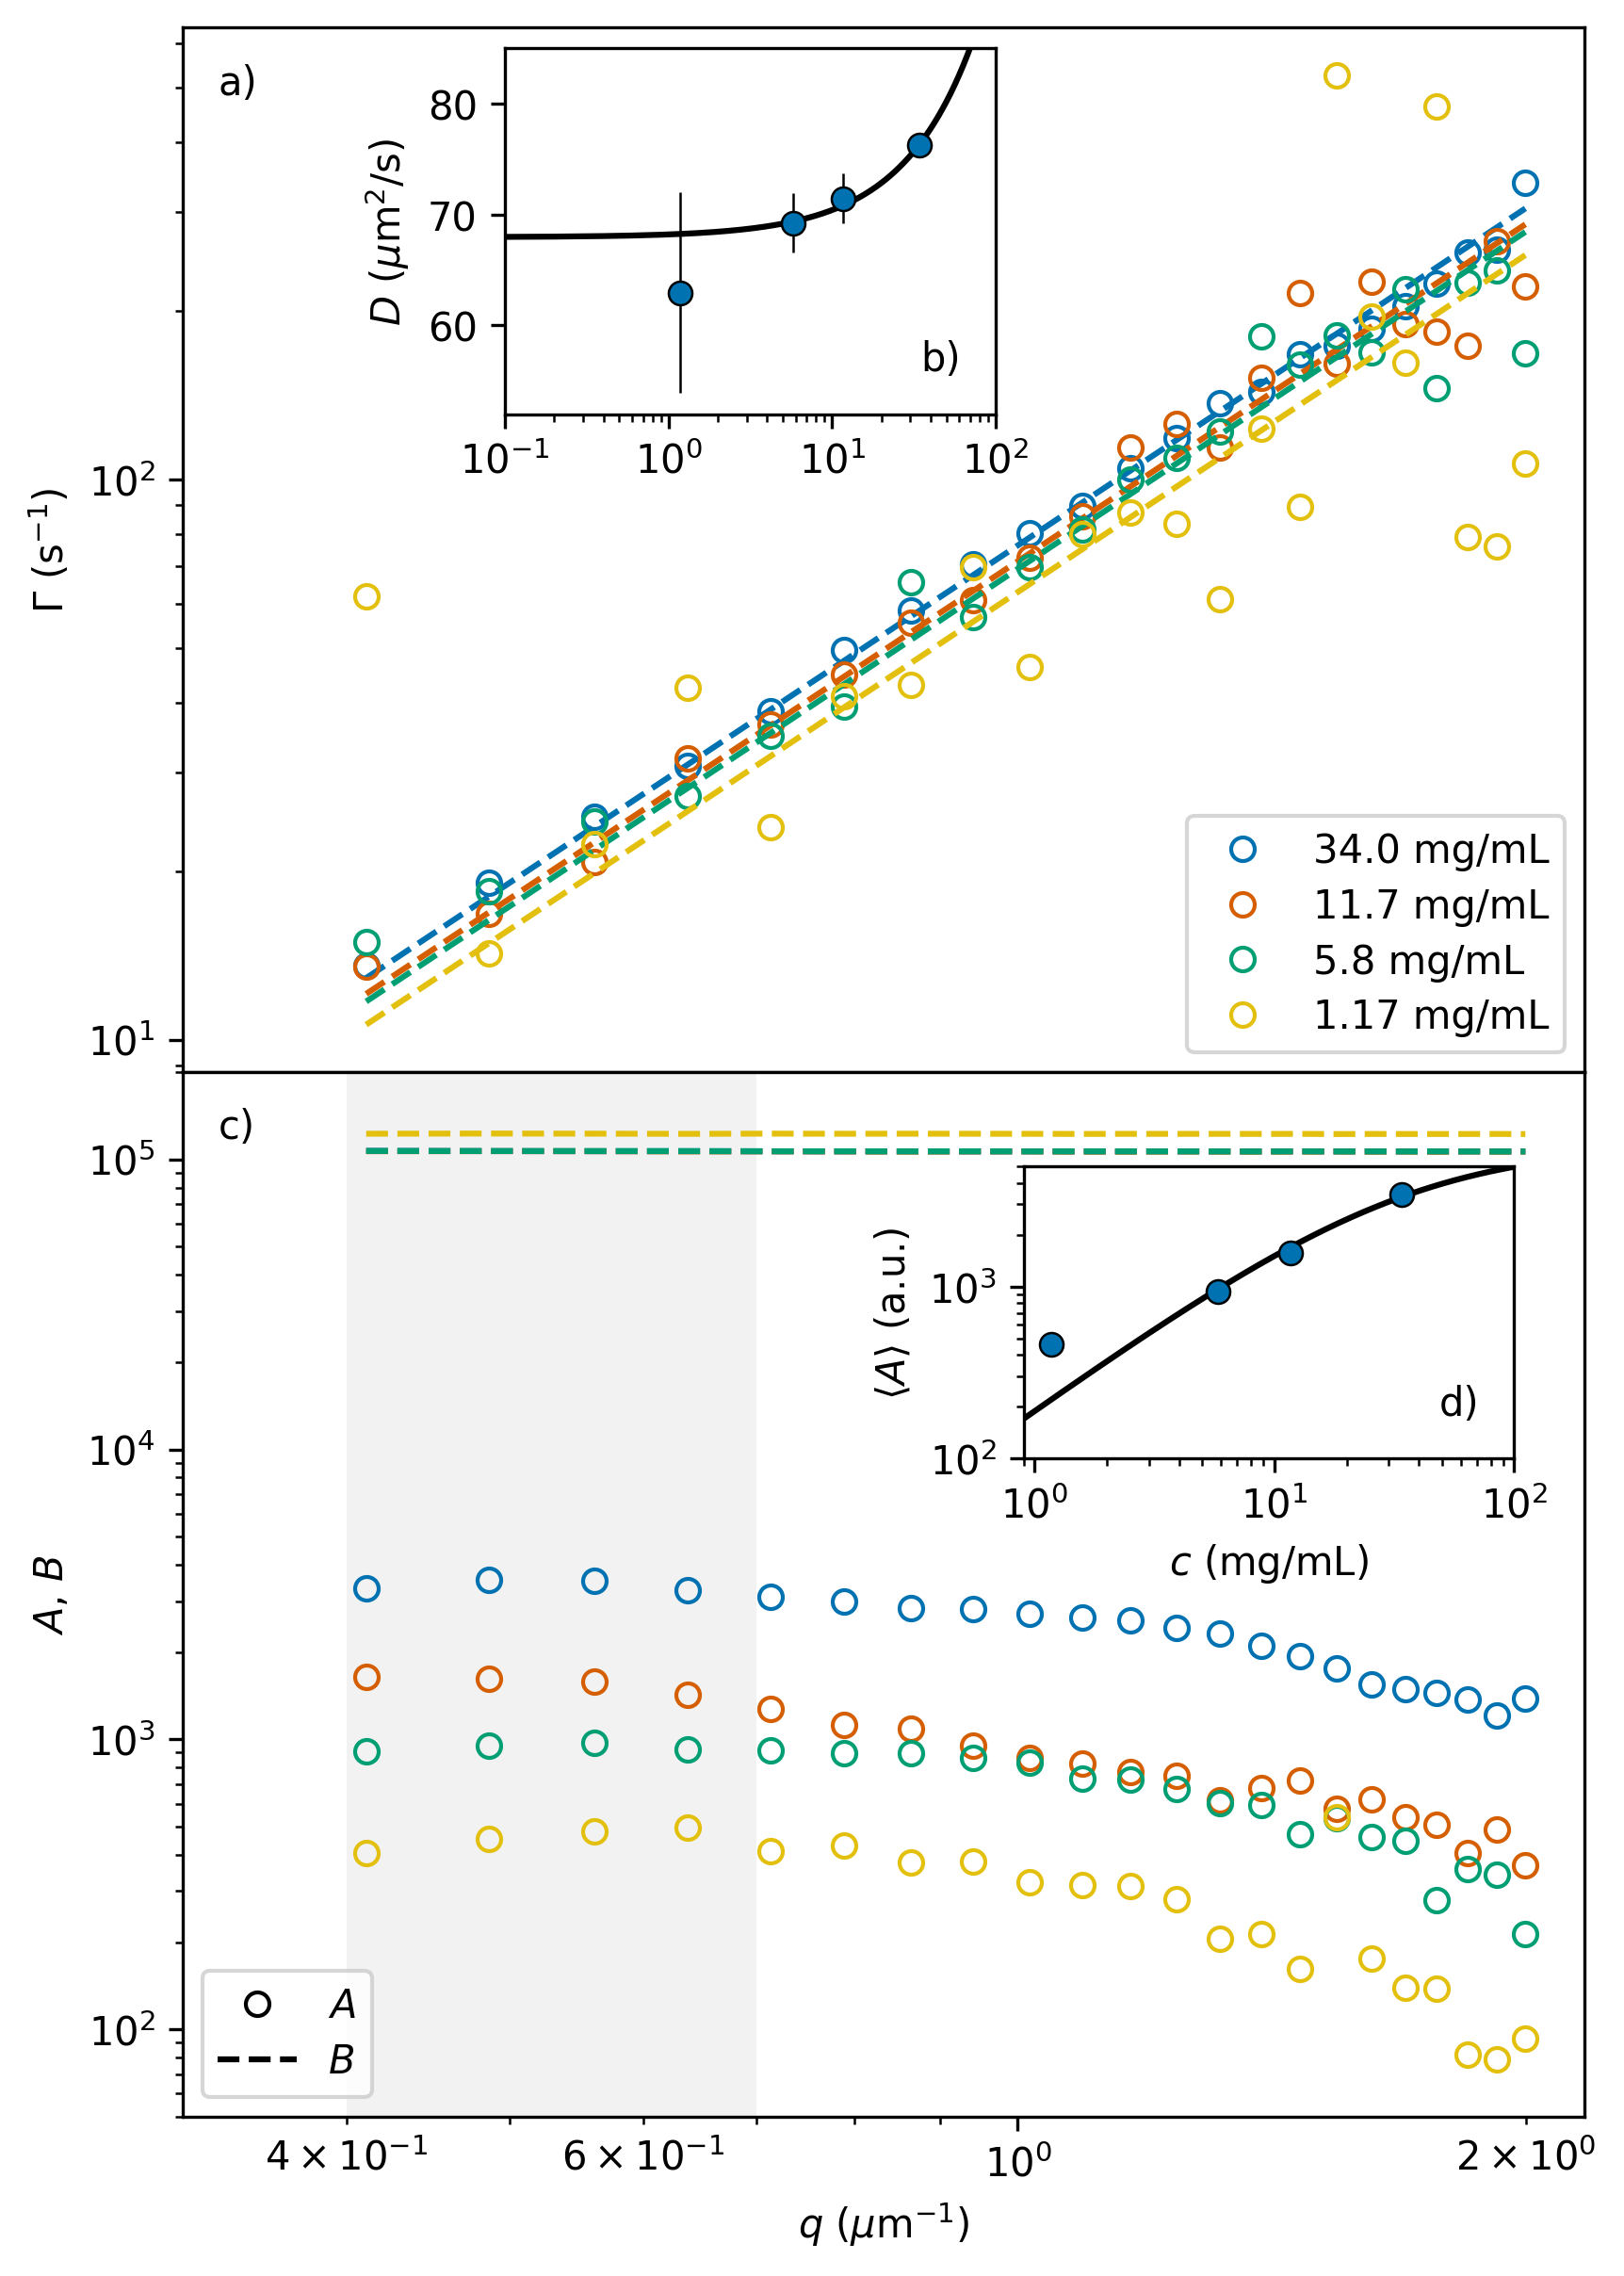

In [9]:
show_transparency = False

fig3 = plt.figure(dpi=300)
fig3.tight_layout()
fig3.set_figheight(2.0 * fig3.get_figheight())
gs3 = fig3.add_gridspec(2, hspace=0)
axs3 = gs3.subplots(sharex=True)

# define k ranges
k_min = [0.4, 0.4, 0.4, 0.4]
k_max = [2.0, 2.0, 2.0, 2.0]
k_mask = []
for n, fr in enumerate(fit_res):
    k_mask.append((fr["k"] >= k_min[n]) & (fr["k"] <= k_max[n]))
    
# fit Gamma in k range
# define model for Gamma
def log_Dq2(x, D):
    return np.log(D * x**2)
model_Gamma = lmfit.Model(log_Dq2, nan_policy="omit")
model_Gamma.set_param_hint("D", min=0.0, value=1.0)

D = []
D_err = []
for n, fr in enumerate(fit_res):
    Gamma_fit_res = fit(model_Gamma, xdata=fr["k"][k_mask[n]], ydata=np.log(fr["Gamma"][k_mask[n]]))
    D.append(Gamma_fit_res.params["D"].value)
    D_err.append(Gamma_fit_res.params["D"].stderr)

# fit D
# define model for D
def D_kD(x, D0, kD):
    return D0 * (1 + kD * x)
model_D = lmfit.Model(D_kD)
model_D.set_param_hint("D0", min=0.0, value=D[-1])
model_D.set_param_hint("kD", min=0.0, value=4.0)


D_fit_res = fit(model_D, xdata=conc, ydata=D, weights=1/np.array(D_err))
D0 = D_fit_res.params["D0"].value
D0err = D_fit_res.params["D0"].stderr
kD = D_fit_res.params["kD"].value
kDerr = D_fit_res.params["kD"].stderr


# compute average amplitude
krange_A = (fit_res[0]["k"] >= 0.4) & (fit_res[0]["k"] <= 0.7)
A = [fr["A"][krange_A].mean() for fr in fit_res]
A_err = [fr["A"][krange_A].std(ddof=1) for fr in fit_res]

# fit A
# define model for A
def virial(x, k, B2):
    return k*x/(1 + x*2*66600*B2)
model_A = lmfit.Model(virial)
model_A.set_param_hint("k", min=0.0, value=1e5)
model_A.set_param_hint("B2", min=0.0, value=1e-8)

A_fit_res = fit(model_A, xdata=conc, ydata=A, weights=1/np.array(A_err))
kfact = A_fit_res.params["k"].value
kfact_err = A_fit_res.params["k"].stderr
B2 = A_fit_res.params["B2"].value
B2_err = A_fit_res.params["B2"].stderr

# plot Gamma data
import seaborn as sns
custom_colors = [
      "#0072B2",  # Blue
      "#D55E00",  # Vermillion
      "#009E73",  # Bluish Green
      "#E3C00D",  # Yellow
      "#CC79A7",  # Reddish Purple
      "#56B4E9",  # Sky Blue
      "#E69F00",  # Orange
      "#000000"   # Black
      ]

  # Register as a Seaborn palette
colors_ = sns.set_palette(sns.color_palette(custom_colors))
colors = sns.color_palette(colors_, n_colors= len(fit_res),)
for n, fr in enumerate(fit_res):
    axs3[0].plot(fr["k"][k_mask[n]], fr["Gamma"][k_mask[n]], f"o", color=colors[n], markerfacecolor="none", label=labels[n])
    if show_transparency:
        axs3[0].plot(fr["k"][~k_mask[n]], fr["Gamma"][~k_mask[n]],  f"o", color=colors[n], markerfacecolor="none", alpha=0.2)
    axs3[0].plot(fr["k"][k_mask[n]], D[n] * fr["k"][k_mask[n]]**2, f"--", color=colors[n],)

# plot diffusion coefficients in inset
axin = axs3[0].inset_axes([0.23, 0.63, 0.35, 0.35])
axin.errorbar(conc, D, yerr=D_err, fmt="C0o", markeredgecolor="k", markeredgewidth=0.6, ecolor="k", elinewidth=0.6)
clin = np.linspace(1e-1, 1e2, num=1000)
axin.plot(clin, D_kD(clin, D0, kD), "-", color="k")
axin.set_xlim(xmin=1e-1, xmax=1e2)
axin.set_ylim(ymax=85)
axin.set_ylabel(r"$c$ (mg/mL)")
axin.set_xscale("log")
axin.set_ylabel(r"$D$ ($\mu$m$^2$/s)")
    
# plot A and B
for n, fr in enumerate(fit_res):
    axs3[1].plot(fr["k"][k_mask[n]], fr["A"][k_mask[n]], f"o", color=colors[n], markerfacecolor="none", label=labels[n])
    #axs3[1].plot(fr["k"][k_mask[n]], fr["B"][k_mask[n]], f"C{n}s", markerfacecolor="none")
    axs3[1].plot(fr["k"][k_mask[n]], Bq[n][k_mask[n]], f"--", color=colors[n])
    if show_transparency:
        axs3[1].plot(fr["k"][~k_mask[n]], fr["A"][~k_mask[n]], f"o",color=colors[n], markerfacecolor="none", alpha=0.2)
        #axs3[1].plot(fr["k"][~k_mask[n]], fr["B"][~k_mask[n]], f"C{n}s", markerfacecolor="none", alpha=0.2)
        axs3[1].plot(fr["k"][~k_mask[n]], B_est["var"][n][~k_mask[n]], f"--",color=colors[n], alpha=0.2)
custom_lines = [Line2D([0], [0], marker="o", linestyle="none", color="black", markerfacecolor="none", label=r"$A$"),
                Line2D([0], [0], linestyle="--", color="black", label=r"$B$")]

axs3[1].fill_betweenx(y=[50,2e5], x1=0.4, x2=0.7, color='gray', alpha=0.1, edgecolor="none")

# plot average amplitude in inset
axin2 = axs3[1].inset_axes([0.60, 0.63, 0.35, 0.28])
axin2.errorbar(conc, A, yerr=A_err, fmt="o", markeredgecolor="k", markeredgewidth=0.6, ecolor="k", elinewidth=0.6)
clin = np.linspace(1e-1, 1e2, num=1000)
axin2.plot(clin, virial(clin, kfact, B2), "-", color="k")
axin2.set_xlabel(r"$c$ (mg/mL)")
axin2.set_xscale("log")
axin2.set_ylabel(r"$\langle A \rangle$ (a.u.)")
axin2.set_yscale("log")
axin2.set_ylim(ymin=1e2, ymax=5e3)
axin2.set_xlim(xmin=0.9, xmax=1e2)


# plot settings
axs3[1].set_xscale("log")
axs3[1].set_xlabel(r"$q$ ($\mu$m$^{-1}$)")
axs3[1].set_xlim(xmin=3.2e-1)
axs3[0].set_yscale("log")
axs3[0].set_ylabel(r"$\Gamma$ (s$^{-1}$)")
axs3[1].set_yscale("log")
axs3[1].set_ylabel(r"$A$, $B$")
axs3[1].set_ylim(50, 2e5)
axs3[0].legend(labelspacing=0.4, loc='lower right')
axs3[1].legend(handles=custom_lines, labelspacing=0.4, loc="lower left")

at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper left'),
    AnchoredText("c)", prop=dict(size=10), frameon=False, loc='upper left'),
]
for a, _at in zip(axs3, at):
    a.add_artist(_at)
axin.add_artist(AnchoredText("b)", prop=dict(size=10), frameon=False, loc='lower right'))
axin2.add_artist(AnchoredText("d)", prop=dict(size=10), frameon=False, loc='lower right'))

# print average speed
print(list(zip(labels,D, D_err)))
print(f"D0: {D0!r} +- {D0err!r} mum2/s")
print(f"kD: {kD!r} +- {kDerr!r} 1/(mg/ml)")
print(f"k: {kfact!r} +- {kfact_err!r} -")
print(f"B2: {1e3*B2!r} +- {1e3*B2_err!r} mol mL/g2")

fig3.savefig("Gamma_AB_bsa_avg_cfr.pdf", dpi=600)

## Show fit results

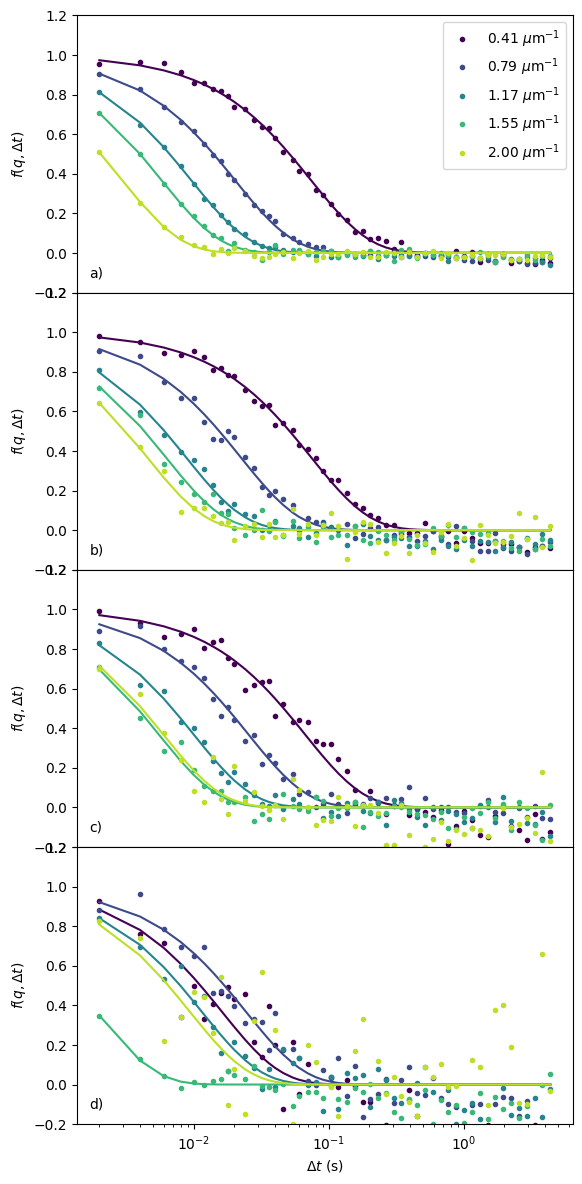

In [10]:
fig21 = plt.figure()
fig21.tight_layout()
fig21.set_figheight(3 * fig21.get_figheight())
gs21 = fig21.add_gridspec(len(aa_res), hspace=0)
axs21 = gs21.subplots(sharex=True, sharey=True)

k_idx = []
cspace = []

for n, (k, K) in enumerate(zip(k_min, k_max)):
    idx_min = np.argwhere(aa_res[n].k >= k)[0,0]
    idx_max = np.argwhere(aa_res[n].k <= K)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=5, dtype=int)
    k_idx.append(k_list)
    cspace.append(color_space(len(k_idx[-1])))

for i, a in enumerate(aa_res):
    for n, k in enumerate(k_idx[i]):
        y = 1 - (a.data[k] - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        y_fit = 1 - (model_res[i][k].best_fit - fit_res[i]['B'][k]) / fit_res[i]['A'][k]
        if i == 0:
            klabel = a.k[k]
            axs21[i].plot(a.tau, y, '.', color=cspace[i][n], label=f"{klabel:.2f} " + r"$\mu$m$^{-1}$")
        else:
            axs21[i].plot(a.tau, y, '.', color=cspace[i][n])
        axs21[i].plot(a.tau, y_fit, '-', color=cspace[i][n])
        

axs21[-1].set_xscale('log')
axs21[-1].set_xlabel(r'$\Delta t$ (s)')
axs21[-1].set_ylim(-0.2, 1.2)
axs21[0].legend()
at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='lower left'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='lower left'),
    AnchoredText("c)", prop=dict(size=10), frameon=False, loc='lower left'),
    AnchoredText("d)", prop=dict(size=10), frameon=False, loc='lower left'),
]
for a, _at in zip(axs21, at):
    a.add_artist(_at)
    a.set_ylabel(r'$f(q, \Delta t)$')

fig21.savefig(f"g1_fit_bsa_avg_cfr.pdf", dpi=600)